## 1. digital filter : separate from each component (base and run-off)

In [1]:
# 구글 드라이브 연결 (파일을 불러오기 위해 필요)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 딥러닝 모형 학습을 위한 기능 import
# -*- coding: utf-8 -*-
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import Model

from keras import layers
from keras.layers import *
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF
!pip install h5py==2.10.0

%matplotlib inline
print(tf.__version__)


TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1.15.2


In [3]:
# 구글 드라이브 파일경로(분석자마다 다르게 설정해야함)
path = '/content/drive/MyDrive/data/ten-day-inflow-avg/'

# 파일 읽기, 소양강 유역의 강우 및 유입량 데이터
df_input = pd.read_csv(path + 'soyang.csv')
df_input

,OBSYMD,DAMCD,RF,IQTY
0,19740101,1012110,0.0000,10.000
1,19740102,1012110,0.0000,9.000
2,19740103,1012110,0.0000,4.800
3,19740104,1012110,0.0000,6.100
4,19740105,1012110,0.0000,5.800
...,...,...,...,...
15985,20171007,1012110,0.1613,6.583
15986,20171008,1012110,0.0000,26.463
15987,20171009,1012110,0.0000,6.836
15988,20171010,1012110,1.9319,19.367


In [4]:
Q = df_input['IQTY'].to_numpy().flatten()
Q

array([10.   ,  9.   ,  4.8  , ...,  6.836, 19.367, 54.967])

In [5]:
a=0.998    #%baseflow filter parameter%

R = np.zeros(len(Q))
B = np.zeros(len(Q))
dif = np.zeros(len(Q))

for k in range(0, len(Q)-1):
  # 다음단계의 R은 현재 R * a와 Q의 변화량의 1/2 * (1+a)를 의미함
  #R(k+1)=a.*R(k)+((1+a).*(Q(k+1)-Q(k)))/2;
  R[k+1] = a * R[k] + ((1+a)*(Q[k+1] - Q[k]))/2
  
  # R이 0보다 작다면, 0으로 처리
  # if R(k+1)<0;
  #   R(k+1)=0;
  if R[k+1] < 0:
    R[k+1] = 0
  
  # R이 Q보다 크면 Q로 처리
  # if R(k+1)>Q(k+1);
  #   R(k+1)=Q(k+1);
  if R[k+1] > Q[k+1]:
    R[k+1] = Q[k+1]

  # B는 Q - R
  #B(k+1)=Q(k+1)-R(k+1);
  B[k+1] = Q[k+1] - R[k+1]

  # dif == R
  #dif(k+1)=Q(k+1)-B(k+1);
  dif[k+1] = Q[k+1] - B[k+1]

df = pd.DataFrame({'Q': Q, 'B': B, 'R': R, 'dif': dif, 'RF' : df_input['RF'] })
df

,Q,B,R,dif,RF
0,10.000,0.000000,0.000000,0.000000,0.0000
1,9.000,9.000000,0.000000,0.000000,0.0000
2,4.800,4.800000,0.000000,0.000000,0.0000
3,6.100,4.801300,1.298700,1.298700,0.0000
4,5.800,4.803597,0.996403,0.996403,0.0000
...,...,...,...,...,...
15985,6.583,5.608193,0.974807,0.974807,0.1613
15986,26.463,5.630023,20.832977,20.832977,0.0000
15987,6.836,5.652062,1.183938,1.183938,0.0000
15988,19.367,5.666960,13.700040,13.700040,1.9319


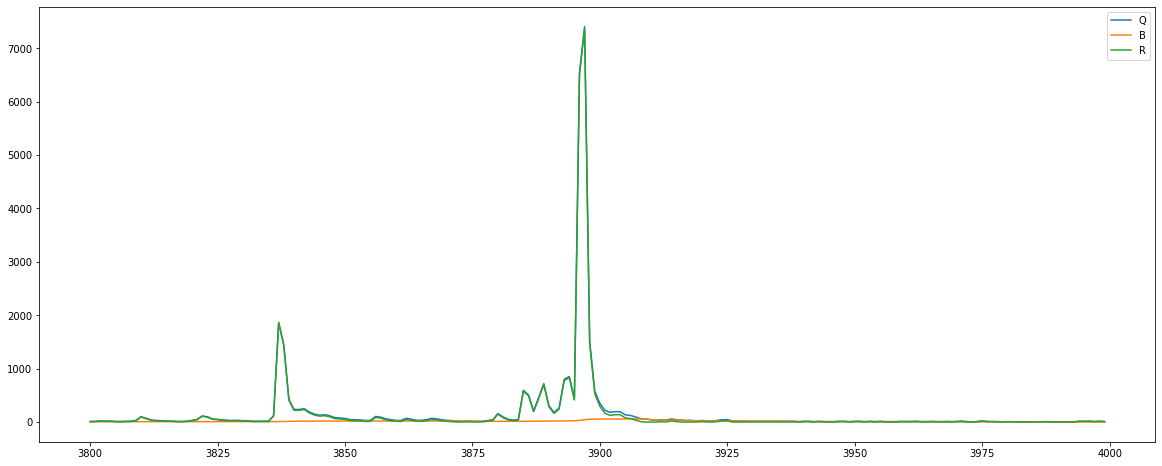

In [6]:
df[['Q', 'B', 'R']][3800:4000].plot(figsize=(20,8))

## 2. Predict Baseflow using LSTM

In [ ]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df[['B', 'RF']].copy()

# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

# 30에 대해 2개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1일 후를 예측으로 함

x_range = 30
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = 'B'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
#print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
#print(dataset_y_reshaped)

#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 15000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:10000,:,:]
X_val = dataset_X_reshaped[10000:15000,:,:]
X_test = dataset_X_reshaped[15000:,:,:]

y_train = dataset_y_reshaped[0:10000]
y_val = dataset_y_reshaped[10000:15000]
y_test = dataset_y_reshaped[15000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15960, 30, 2)
(15960, 1)
(10000, 30, 2)
(960, 30, 2)
(10000, 1)
(960, 1)


In [ ]:
# 기본 lstm모형을 생성
# lstm 은 stacked lstm형태로, stacked될 경우 return_sequence = TRUE 옵션 필요
# training=True옵션을 통해 dropout을 이용하여 매번 다른 결과값이 생성됨
# early stopping을 적용하여, 최적의 epoch를 결정함
# 현재 patience는 5로 설정되어 있음

drop_out_rate = 0.05

def base_lstm(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x1 = LSTM(8, return_sequences=True, recurrent_dropout=drop_out_rate)(inputs) 
  x2 = LSTM(8, recurrent_dropout=drop_out_rate)(x1) 
  x3 = Dropout(drop_out_rate)(x2) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x3)
  model = Model(inputs=inputs, outputs=output)

  opt = Adam()

  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
  
  
  
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=128)
  return model
 
model_base = base_lstm(X_train, y_train)


Train on 10000 samples, validate on 5000 samples
Epoch 1/1000
10000/10000 [==============================] - 3s 321us/step - loss: 155.1659 - mae: 8.0936 - val_loss: 134.8923 - val_mae: 6.5593
Epoch 2/1000
10000/10000 [==============================] - 2s 233us/step - loss: 125.1512 - mae: 6.9147 - val_loss: 119.6301 - val_mae: 6.3793
Epoch 3/1000
10000/10000 [==============================] - 2s 228us/step - loss: 112.0949 - mae: 6.6057 - val_loss: 113.3086 - val_mae: 6.4287
Epoch 4/1000
10000/10000 [==============================] - 2s 225us/step - loss: 105.3913 - mae: 6.5122 - val_loss: 108.9050 - val_mae: 6.4315
Epoch 5/1000
10000/10000 [==============================] - 2s 233us/step - loss: 96.2361 - mae: 5.7445 - val_loss: 96.3689 - val_mae: 4.9226
Epoch 6/1000
10000/10000 [==============================] - 2s 226us/step - loss: 87.8921 - mae: 5.1032 - val_loss: 89.9723 - val_mae: 4.5802
Epoch 7/1000
10000/10000 [==============================] - 2s 243us/step - loss: 81.4762 

In [ ]:
y_pred = model_base.predict(X_test)
y_obs = y_test

In [ ]:
df_pred = pd.DataFrame({'Date' : df_input['OBSYMD'][15030:].values, 'Obs' : y_obs.flatten(), 'Pred' : y_pred.flatten(), 'RF' : df_input['RF'][15030:].values})
df_pred['Date'] = df_pred['Date'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d')) 

df_pred

,Date,Obs,Pred,RF
0,2015-02-25,0.278647,0.410658,0.7594
1,2015-02-26,0.306126,0.417957,0.8506
2,2015-02-27,0.323314,0.435310,0.0000
3,2015-02-28,0.336981,0.444144,0.0000
4,2015-03-01,0.347468,0.451094,0.0000
...,...,...,...,...
955,2017-10-07,5.608193,5.514189,0.1613
956,2017-10-08,5.630023,5.514099,0.0000
957,2017-10-09,5.652062,5.513100,0.0000
958,2017-10-10,5.666960,5.520998,1.9319


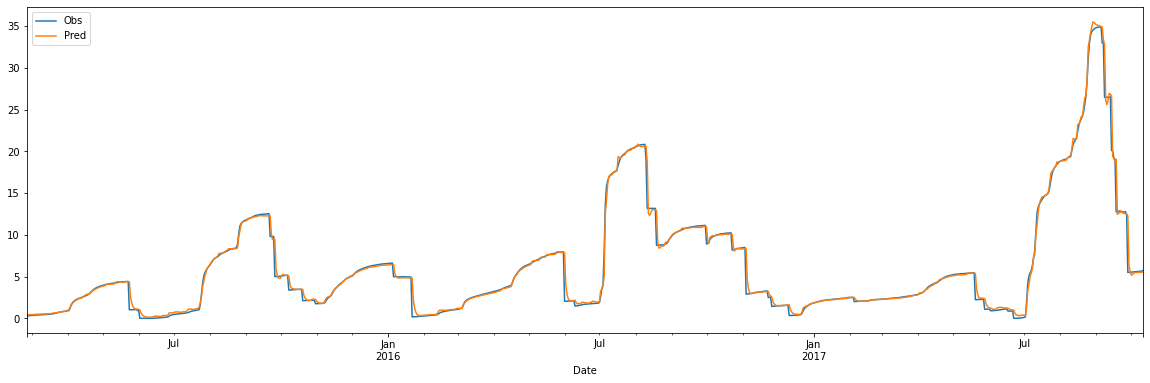

In [ ]:
df_pred[['Date', 'Obs', 'Pred']].set_index('Date').plot(figsize=(20,6))

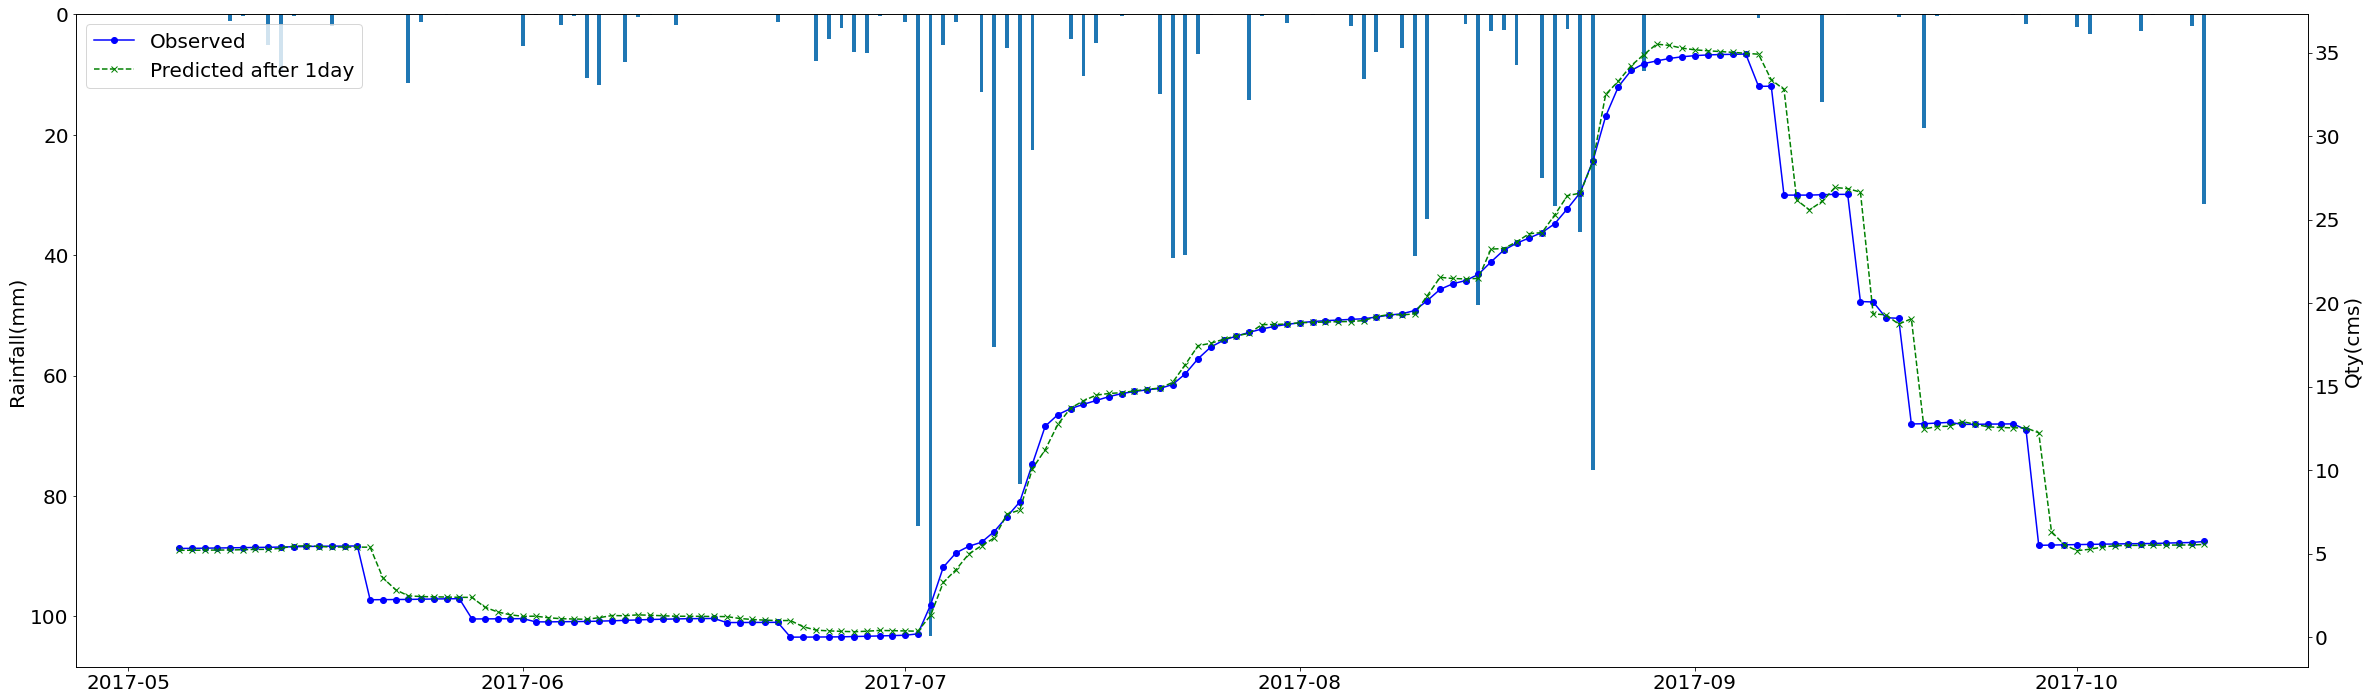

In [ ]:
df_predict = df_pred[800:1000].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1day'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

## 3. Predict run-off using LSTM

In [7]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df[['R', 'RF']].copy()

# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

# 30에 대해 2개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1일 후를 예측으로 함

x_range = 30
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = 'R'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
#print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
#print(dataset_y_reshaped)

#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 15000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:10000,:,:]
X_val = dataset_X_reshaped[10000:15000,:,:]
X_test = dataset_X_reshaped[15000:,:,:]

y_train = dataset_y_reshaped[0:10000]
y_val = dataset_y_reshaped[10000:15000]
y_test = dataset_y_reshaped[15000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15960, 30, 2)
(15960, 1)
(10000, 30, 2)
(960, 30, 2)
(10000, 1)
(960, 1)


In [20]:
# 기본 lstm모형을 생성
# lstm 은 stacked lstm형태로, stacked될 경우 return_sequence = TRUE 옵션 필요
# training=True옵션을 통해 dropout을 이용하여 매번 다른 결과값이 생성됨
# early stopping을 적용하여, 최적의 epoch를 결정함
# 현재 patience는 5로 설정되어 있음

drop_out_rate = 0.05

def base_lstm(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = LSTM(64, return_sequences=True)(inputs) 
  x = BatchNormalization()(x)
  x = LSTM(32, return_sequences=True)(x) 
  x = BatchNormalization()(x)
  x = LSTM(16, return_sequences=False)(x) 
  x = BatchNormalization()(x)
  x = Dropout(drop_out_rate)(x) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)

  opt = Adam()

  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
  
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=128)
  return model
 
model_base = base_lstm(X_train, y_train)

Train on 10000 samples, validate on 5000 samples
Epoch 1/1000
10000/10000 [==============================] - 18s 2ms/step - loss: 52007.3402 - mae: 59.1066 - val_loss: 56646.1023 - val_mae: 65.2545
Epoch 2/1000
10000/10000 [==============================] - 9s 903us/step - loss: 51078.9047 - mae: 58.5371 - val_loss: 56351.7128 - val_mae: 63.7231
Epoch 3/1000
10000/10000 [==============================] - 11s 1ms/step - loss: 50311.5615 - mae: 57.6787 - val_loss: 56018.2019 - val_mae: 62.4939
Epoch 4/1000
10000/10000 [==============================] - 9s 939us/step - loss: 49580.6952 - mae: 56.5898 - val_loss: 55745.6656 - val_mae: 62.1025
Epoch 5/1000
10000/10000 [==============================] - 9s 921us/step - loss: 48848.0467 - mae: 55.2752 - val_loss: 56048.9874 - val_mae: 64.2836
Epoch 6/1000
10000/10000 [==============================] - 9s 917us/step - loss: 47817.0980 - mae: 53.6726 - val_loss: 53445.2707 - val_mae: 59.7985
Epoch 7/1000
10000/10000 [===========================

In [21]:
y_pred = model_base.predict(X_test)
y_obs = y_test

In [22]:
df_pred = pd.DataFrame({'Date' : df_input['OBSYMD'][15030:].values, 'Obs' : y_obs.flatten(), 'Pred' : y_pred.flatten(), 'RF' : df_input['RF'][15030:].values})
df_pred['Date'] = df_pred['Date'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d')) 

df_pred

,Date,Obs,Pred,RF
0,2015-02-25,17.139353,27.925392,0.7594
1,2015-02-26,10.311874,29.122171,0.8506
2,2015-02-27,6.858686,29.336575,0.0000
3,2015-02-28,6.795019,28.280754,0.0000
4,2015-03-01,3.681532,27.694216,0.0000
...,...,...,...,...
955,2017-10-07,0.974807,30.976540,0.1613
956,2017-10-08,20.832977,29.204506,0.0000
957,2017-10-09,1.183938,29.393005,0.0000
958,2017-10-10,13.700040,28.130308,1.9319


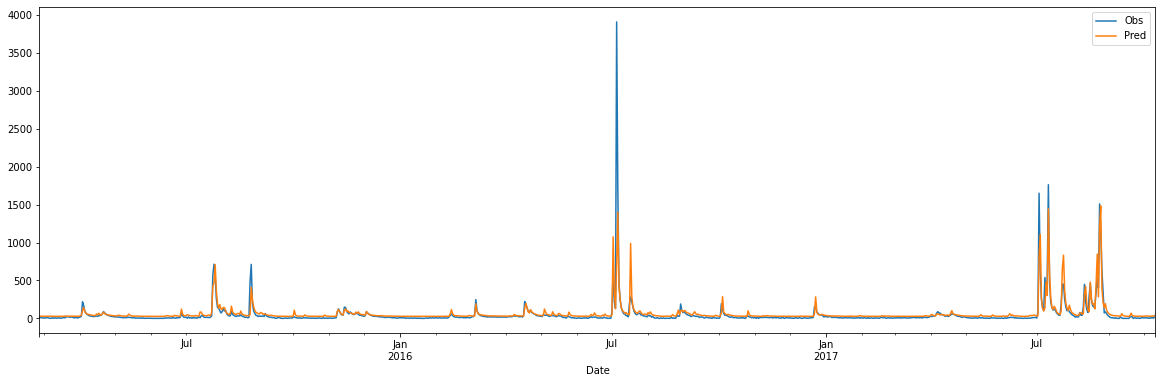

In [23]:
df_pred[['Date', 'Obs', 'Pred']].set_index('Date').plot(figsize=(20,6))

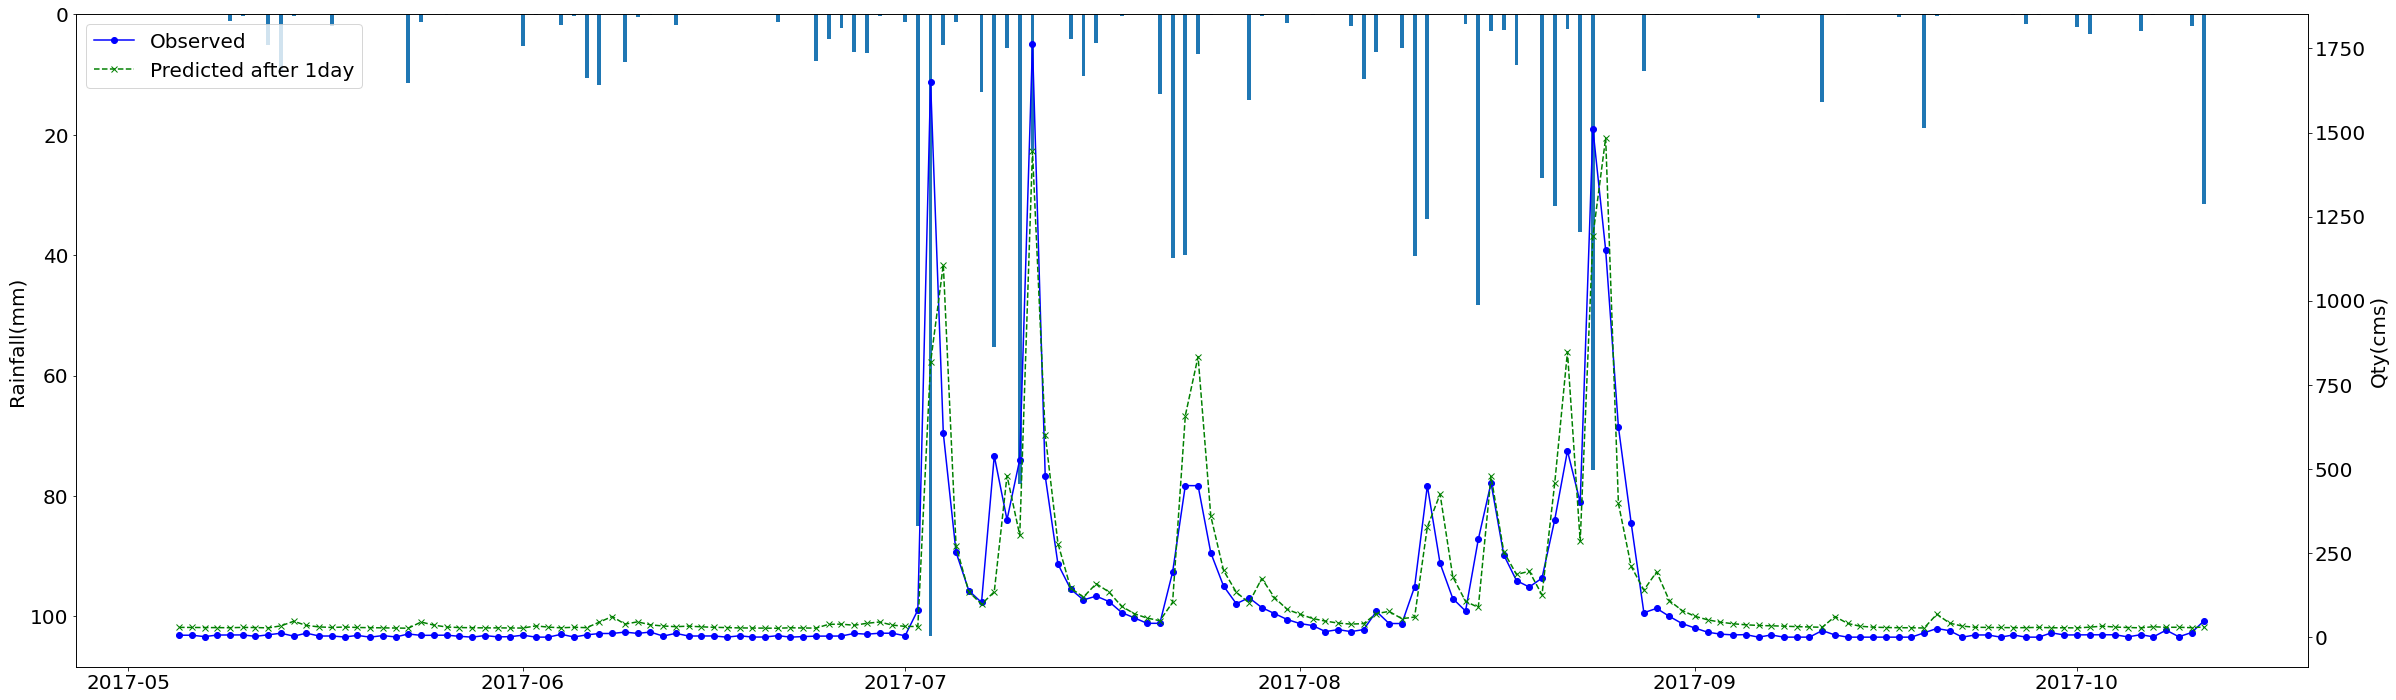

In [24]:
df_predict = df_pred[800:1000].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1day'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

## 4. Combine 2 & 3